# Projekt 2: Traffic Sign Classification

### Dependencies

In [1]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
import pickle as pickle
import sklearn as sklearn
from matplotlib import pyplot as pp

### Traffic Classifier class: tfclassify

In [2]:
class tfclassify():
    def __init__(self,X_train=None,y_train=None,X_valid=None,y_valid=None):
        if X_train is None:
            self.loadPickleData()
        self.x = tf.placeholder(tf.float32, (None, self.X_train[0].shape[0],self.X_train[0].shape[1], self.X_train[0].shape[2]))
        self.y = tf.placeholder(tf.int32, (None))
        self.one_hot_y = tf.one_hot(self.y, max(self.y_train)+1) # Only works if labels start at zero
        self.keep_prob = tf.placeholder(tf.float32)
        self.net = None
        self.current_input_shape = self.X_train[0].shape
        self.layerNr = 0

##### Load data from pickle files
    def loadPickleData(self,trainingdata_p='tfdata/train.p',validationdata_p='tfdata/valid.p',testdata_p='tfdata/test.p'):
        print('Loading TrafficSignData....')
        try:
            with open(trainingdata_p, mode='rb') as f:
                train = pickle.load(f)
            with open(validationdata_p, mode='rb') as f:
                valid = pickle.load(f)
            with open(testdata_p, mode='rb') as f:
                test = pickle.load(f)
        except Exception as e:
            print('Data could not be loaded: ',str(e))
            return 0
        self.X_train, self.y_train = train['features'],train['labels']
        self.X_valid, self.y_valid = valid['features'],valid['labels']
        self.X_test, self.y_test = test['features'],test['labels']
        print('Data loaded sucessfully')

    def grayscaleData(self):
        raise NotImplementedError
##### Normalize training/validation/test data
    def normalizeData(self):
        self.X_train = (self.X_train.astype(dtype=float)-128.0)/128.0
        self.X_valid = (self.X_valid.astype(dtype=float)-128.0)/128.0
        self.X_test = (self.X_test.astype(dtype=float)-128.0)/128.0

##### Display information on Data
    def dataAnalysis(self):
        print('DATA INFORMATION')
        print('----------------------------')
        print('Overall number of training smaples:', len(self.y_train))
        print('Overall number of validation smaples:', len(self.y_valid))
        print('Overall number of test smaples:', len(self.y_test))
        print('Overall number of different labels:', max(self.y_train)+1) #Starting with Label 0 to Label 42
        print('\n')
        print('FEATURE INFORMATION')
        print('----------------------------')
        print('Image Size:',self.X_train[0].shape[0],'x',self.X_train[0].shape[0])
        print('Image Depth:',self.X_train[0].shape[2])
        print('\n')
        print('LABEL INFORMATION(n=total number of labels,r=ratio regarding n_train+,n_valid+n_test per Label)')
        print('----------------------------')
        train_unique, train_counts = np.unique(self.y_train, return_counts=True)
        valid_unique, valid_counts = np.unique(self.y_valid, return_counts=True)
        test_unique, test_counts = np.unique(self.y_test, return_counts=True)
        for tr_l,tr_c,va_l,va_c,te_l,te_c in zip(train_unique,train_counts,valid_unique,valid_counts,test_unique,test_counts):
            if tr_l == te_l & va_l==tr_l:
                total = tr_c+te_c+va_c
                print('Label: {0:02d} n_train: {1:04d} n_valid: {2:04d} n_test: {3:04d} r_train: {4:2.2f} valid: {5:2.2f} test: {6:2.2f}'.format(tr_l, tr_c, va_c, te_c,(tr_c/total),(va_c/total),(te_c/total)))
            else:
                raise Exception('Data Error: Data missing or unsorted')

##### Add convolutional layer
    def addLayerConvolutional(self, shape, mean, stddev, strides, padding):
        self.__checkShape(shape)
        self.__checkPadding(padding)
        input_dim = self.current_input_shape
        weights = tf.Variable(tf.truncated_normal(shape = shape,mean = mean, stddev = stddev))
        biases = tf.Variable(tf.zeros(shape[-1]))
        if self.net is None:
            self.net = tf.nn.conv2d(self.x, filter=weights, strides=strides, padding=padding) + biases
        else:
            self.net = tf.nn.conv2d(self.net,weights,strides,padding)+biases
        self.__calcOutputShape(padding=padding,strides=strides,shape=shape)
        self.layerNr += 1
        print('Added Convolutional Layer as Layer',self.layerNr,'with input dimensions',input_dim,'and output dimensions',self.current_input_shape)

##### Add Fully Connected Layer
    def addLayerFullyConnected(self, shape, mean, stddev):
        input_dim = self.current_input_shape
        if self.current_input_shape[1] != np.prod(np.array(self.current_input_shape)): #Test if data has been flattened
            self.net = tf.contrib.layers.flatten(self.net)
        if shape[0] == np.prod(np.array(self.current_input_shape)): #Test if input for fully connected meets output
            weights = tf.Variable(tf.truncated_normal(shape=shape,mean = mean, stddev = stddev))
            biases = tf.Variable(tf.zeros(shape[-1]))
            self.net = tf.matmul(self.net,weights) + biases
            self.__calcOutputShape(flat=shape)
            self.layerNr += 1
        else:
            raise Exception('Wrong input dimensions')
        print('Added Fully Connected Layer as Layer',self.layerNr,'with input dimensions',input_dim,'and output dimensions',self.current_input_shape)
##### Add activation to layer
    def addLayerActivation(self,activationType='relu'):
        if self.net is None:
            raise Exception('Couldn`t add activation - nothing to activate')
        if activationType == 'relu':
            self.net = tf.nn.relu(self.net)
        else:
            raise Exception('Unkown activation type: Type must be `relu` or TODO')
        print('Added Activation to Layer',self.layerNr,'with type', activationType)
##### Add Pooling to layer
    def addLayerPooling(self, kernel_size, strides, padding):
        input_dim = self.current_input_shape
        self.__checkPadding(padding)
        self.__checkStrides(strides)    
        self.net = tf.nn.max_pool(self.net, ksize=kernel_size, strides=strides, padding=padding)
        self.__calcOutputShape(padding=padding,strides=strides,kernel = kernel_size)
        print('Added Pooling to Layer',self.layerNr,'with input dimensions',input_dim,'and output dimensions',self.current_input_shape)

##### Dropout not implemented at current point
    def addLayerDropout(self):
        raise NotImplementedError
##### L2 Regularisation not implemented at current point
    def L2Regularisation(self):
        raise NotImplementedError
##### Returns TrainingSets with equal number of features per label
    def evenSets(self, setSize):
        train_final_x = np.zeros([(max(self.y_train)+1)*setSize,self.X_train[0].shape[0],self.X_train[0].shape[1],self.X_train[0].shape[2]],dtype='uint8')
        train_final_y = np.zeros((max(self.y_train)+1)*setSize)
        for i in range(max(self.y_train)+1):
            X_train = self.X_train[self.y_train==i]
            if setSize>X_train.shape[0]:
                raise Exception('SetSize exceeds Size of data of ',X_train.shape[1])
            train_final_x[i*setSize:(i+1)*setSize-1] = sklearn.utils.shuffle(X_train)[:(setSize-1)]
            train_final_y[i*setSize:(i+1)*setSize-1] = i
        return sklearn.utils.shuffle(train_final_x,train_final_y)

##### Default LeNet from LeNet Lab        
    def addDefaultLeNet(self):
        #Adds default LeNet as in LeNetLab changed to 3 Channels
        self.addLayerConvolutional(shape=(5, 5, self.current_input_shape[-1], 6),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
        self.addLayerActivation()
        self.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        self.addLayerConvolutional(shape=(5, 5, 6, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
        self.addLayerActivation()
        self.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        self.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
        self.addLayerActivation()
        self.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
        self.addLayerActivation()
        self.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

##### Final TrafficSign Classifier
    def tfLeNet(self):
        self.addLayerConvolutional(shape=(5, 5, 3, 7), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
        self.addLayerActivation()
        self.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
        #### Extra layer
        self.addLayerConvolutional(shape=(3, 3, 7, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
        self.addLayerActivation()
        self.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        #### End of extra layer
        self.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
        self.addLayerActivation()
        self.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        self.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
        self.addLayerActivation()
        self.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
        self.addLayerActivation()
        self.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

##### Training Setup
    def trainingSetup(self,training_rate=0.001,batch_size=128,epochs=10,usedecay=False):
        if self.net is None:
            raise Exception('No ConvNet initialized')
        self.X_train, self.y_train = sklearn.utils.shuffle(self.X_train, self.y_train)
        self.training_rate = training_rate
        self.batch_size = batch_size
        self.epochs = epochs
        logits = self.net
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=logits)
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = training_rate)
        if usedecay:
            self.training_operation = optimizer.minimize(loss_operation,global_step=global_step)
        else:
            self.training_operation = optimizer.minimize(loss_operation)
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print('Configured LeNet training setup with training rate:', training_rate, 'batch size:', batch_size, 'and epochs:', epochs)
        self.saver =tf.train.Saver()
        
##### Training operation
    def train(self,saveTo=None,useEqualSets=False):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(self.X_train)
            print("Training...")
            print()
            for i in range(self.epochs):
                if useEqualSets:
                    X_train, y_train = self.evenSets(180)
                else:
                    X_train, y_train = sklearn.utils.shuffle(self.X_train, self.y_train)
                for offset in range(0, num_examples, self.batch_size):
                    end = offset + self.batch_size
                    batch_x, batch_y = self.X_train[offset:end], self.y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={self.x: batch_x, self.y: batch_y})
            
                validation_accuracy = self.__evaluate(self.X_valid, self.y_valid)
                print("EPOCH {} ...".format(i+1))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
            
            if saveTo is not None:
                self.saver.save(sess, './modeldata/' + saveTo)
                print("Model saved to " + saveTo)

##### Test operation 
    def test(self):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, tf.train.latest_checkpoint('./modeldata/'))
            test_accuracy = self.__evaluate(self.X_test, self.y_test)
            print("Test Accuracy = {:.3f}".format(test_accuracy))
##### Prediction
    def predict(self,img):
        feature = np.expand_dims((img.astype(dtype=float)-128.0)/128.0,axis=0)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, tf.train.latest_checkpoint('./modeldata/'))
            probabilities = sess.run(tf.nn.softmax(self.net), feed_dict={self.x: feature})
            prediction = sess.run(tf.argmax(probabilities,1))
            return probabilities, prediction
##### Private Functions
    def __checkPadding(self,padding):
        if not (padding=='VALID' or padding=='SAME'):
            raise Exception('Padding must be `VALID` or `SAME`')

    def __checkShape(self, shape):
        if type(shape) is not tuple:
            raise Exception('Shape must be of type `tuple`')


    def __checkStrides(self, strides):
        if type(strides) is not list:
            raise Exception('Shape must be of type `tuple`')

    def __calcOutputShape(self,padding=None,strides=None,shape=None,kernel=None,flat=None):
        if shape is not None:
            if padding=='SAME':
                pad_vert=(shape[0]-1)/2
                pad_hori=(shape[1]-1)/2
            else:
                pad_vert = 0
                pad_hori = 0
            depth = shape[-1]
            height = (self.current_input_shape[0]-shape[0]+2*pad_vert)/strides[1]+1
            width  = (self.current_input_shape[1]-shape[1]+2*pad_hori)/strides[2]+1
        elif kernel is not None:
            if padding=='SAME':
                pad_vert=(kernel[1]-1)/2
                pad_hori=(kernel[2]-1)/2
            else:
                pad_vert = 0
                pad_hori = 0
            depth = self.current_input_shape[-1]
            height = (self.current_input_shape[0]-kernel[1]+2*pad_vert)/strides[1]+1
            width  = (self.current_input_shape[1]-kernel[2]+2*pad_hori)/strides[2]+1

        elif flat is not None:
            width = 1
            depth = 1
            height = flat[-1]  
            
        self.current_input_shape = (height, width, depth)

    def __evaluate(self,X_data,y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.batch_size):
            batch_x, batch_y = X_data[offset:offset+self.batch_size], y_data[offset:offset+self.batch_size]
            accuracy = sess.run(self.accuracy_operation, feed_dict={self.x: batch_x, self.y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

### Look at the data

In [26]:
tfc = tfclassify()
tfc.dataAnalysis()

Loading TrafficSignData....
Data loaded sucessfully
DATA INFORMATION
----------------------------
Overall number of training smaples: 34799
Overall number of validation smaples: 4410
Overall number of test smaples: 12630
Overall number of different labels: 43


FEATURE INFORMATION
----------------------------
Image Size: 32 x 32
Image Depth: 3


LABEL INFORMATION(n=total number of labels,r=ratio regarding n_train+,n_valid+n_test per Label)
----------------------------
Label: 00 n_train: 0180 n_valid: 0030 n_test: 0060 r_train: 0.67 valid: 0.11 test: 0.22
Label: 01 n_train: 1980 n_valid: 0240 n_test: 0720 r_train: 0.67 valid: 0.08 test: 0.24
Label: 02 n_train: 2010 n_valid: 0240 n_test: 0750 r_train: 0.67 valid: 0.08 test: 0.25
Label: 03 n_train: 1260 n_valid: 0150 n_test: 0450 r_train: 0.68 valid: 0.08 test: 0.24
Label: 04 n_train: 1770 n_valid: 0210 n_test: 0660 r_train: 0.67 valid: 0.08 test: 0.25
Label: 05 n_train: 1650 n_valid: 0210 n_test: 0630 r_train: 0.66 valid: 0.08 test: 0.25

### Display Signs

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


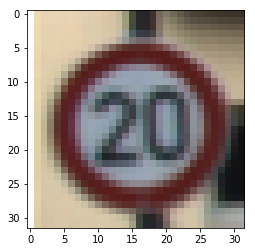

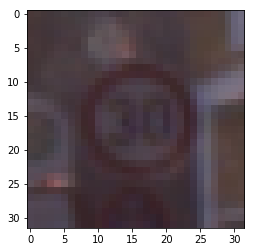

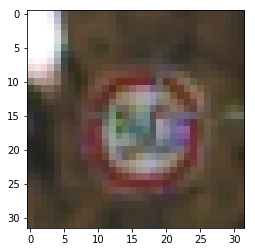

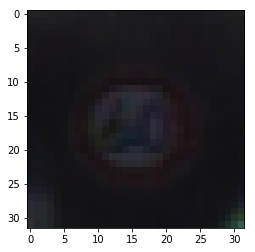

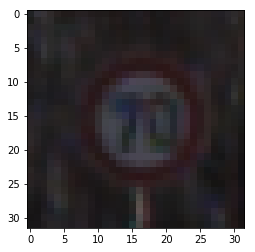

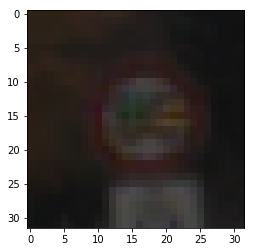

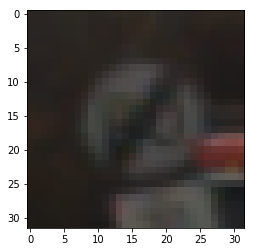

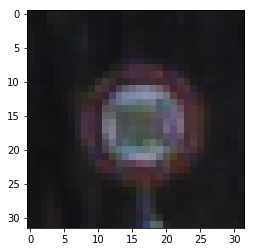

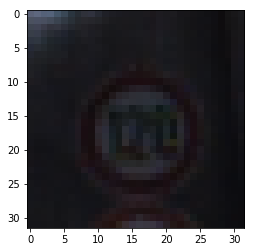

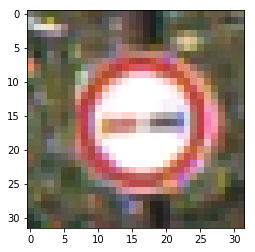

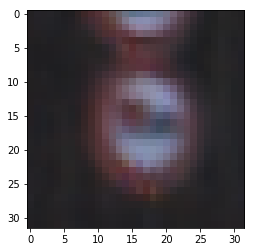

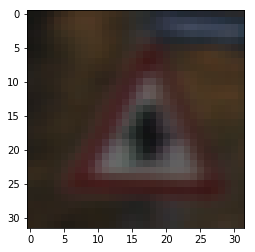

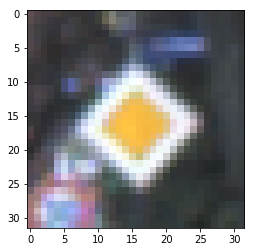

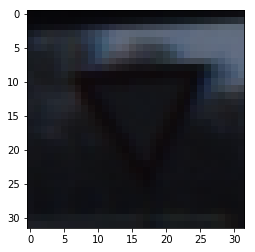

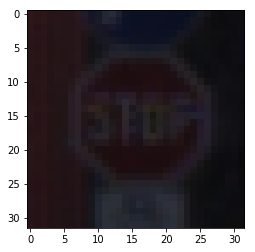

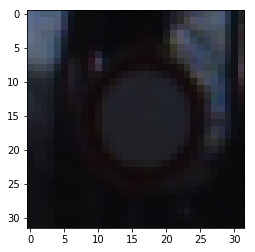

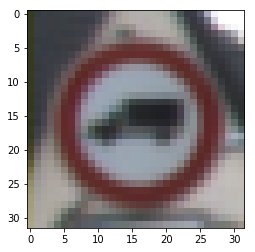

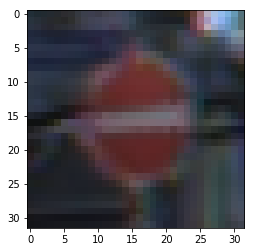

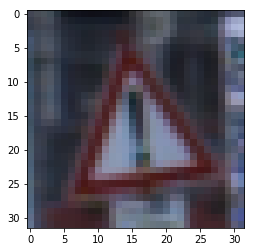

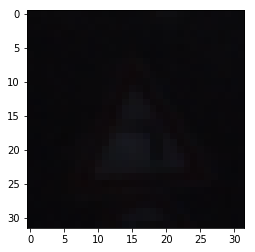

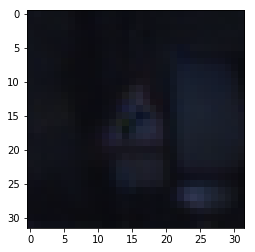

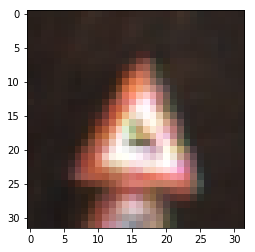

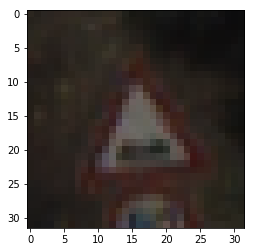

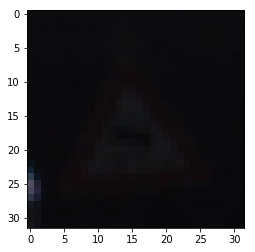

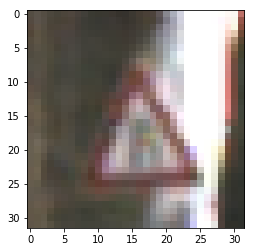

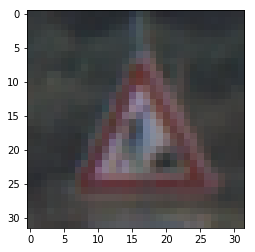

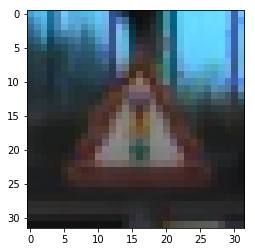

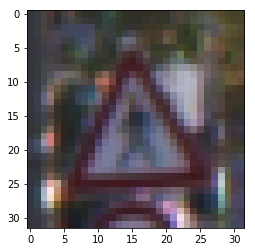

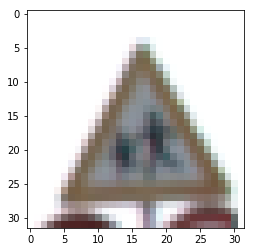

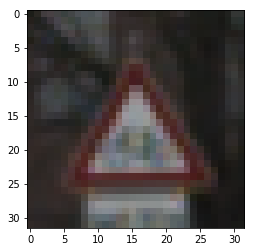

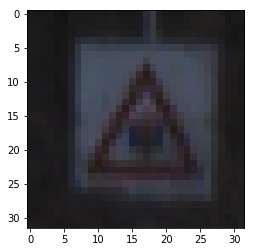

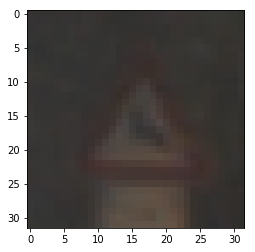

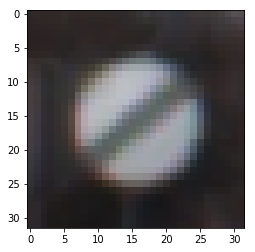

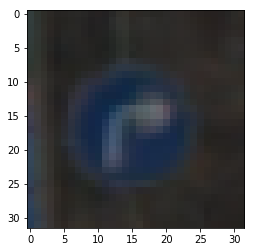

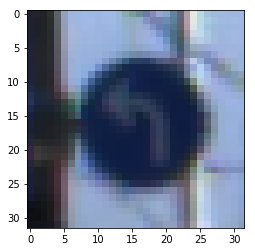

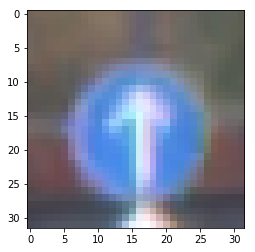

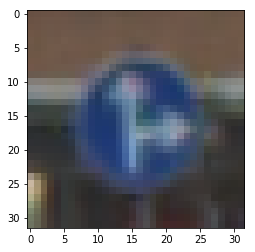

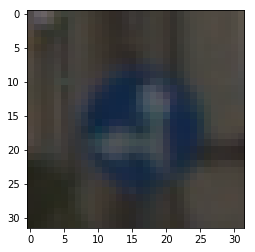

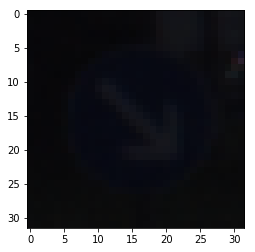

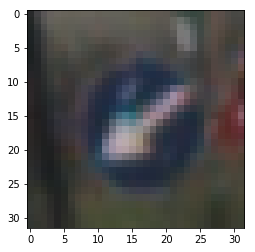

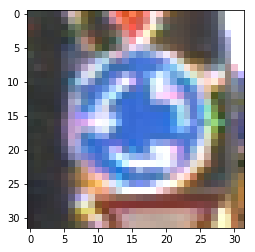

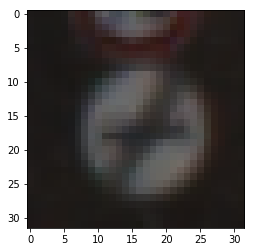

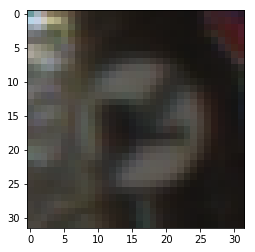

In [33]:
from matplotlib import pyplot
%matplotlib inline
for i in range(43):
    pyplot.figure()
    pyplot.imshow(tfc.X_train[tfc.y_train==i][0])

### Default setup

In [3]:

tfc.addDefaultLeNet()
tfc.trainingSetup()
tfc.train(saveTo='defaultSetup')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

### Default setup, 100 epochs

In [4]:
tfc = tfclassify()
tfc.addDefaultLeNet()
tfc.trainingSetup(epochs=100)
tfc.train(saveTo='defaultSetup100epochs')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

### Default Setup, 256 batch size

In [5]:
tfc = tfclassify()
tfc.addDefaultLeNet()
tfc.trainingSetup(batch_size=256)
tfc.train(saveTo='defaultSetupbatch256')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

### Default Setup, decaying learning rate

In [6]:
tfc = tfclassify()
tfc.addDefaultLeNet()
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.001, global_step, 10, 1, staircase=True)
tfc.trainingSetup(usedecay=True,training_rate=learning_rate)
tfc.train(saveTo='defaultsetupdecaylearningrate')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

### Default Setup, 100 epochs, decaying learning rate

In [7]:
tfc = tfclassify()
tfc.addDefaultLeNet()
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.001, global_step, 10, 1, staircase=False)
tfc.trainingSetup(usedecay=True,training_rate=learning_rate,batch_size=128,epochs=100)
tfc.train(saveTo='decay')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

### Default Setup, 0.0001 learning rate, 200 epochs

In [8]:
tfc = tfclassify()
tfc.addDefaultLeNet()
tfc.trainingSetup(training_rate=0.0001,batch_size=128,epochs=200)
tfc.train(saveTo='lrate10-4_200epochs')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

EPOCH 170 ...
Validation Accuracy = 0.884

EPOCH 171 ...
Validation Accuracy = 0.884

EPOCH 172 ...
Validation Accuracy = 0.883

EPOCH 173 ...
Validation Accuracy = 0.884

EPOCH 174 ...
Validation Accuracy = 0.884

EPOCH 175 ...
Validation Accuracy = 0.884

EPOCH 176 ...
Validation Accuracy = 0.884

EPOCH 177 ...
Validation Accuracy = 0.884

EPOCH 178 ...
Validation Accuracy = 0.884

EPOCH 179 ...
Validation Accuracy = 0.884

EPOCH 180 ...
Validation Accuracy = 0.883

EPOCH 181 ...
Validation Accuracy = 0.884

EPOCH 182 ...
Validation Accuracy = 0.884

EPOCH 183 ...
Validation Accuracy = 0.884

EPOCH 184 ...
Validation Accuracy = 0.871

EPOCH 185 ...
Validation Accuracy = 0.884

EPOCH 186 ...
Validation Accuracy = 0.879

EPOCH 187 ...
Validation Accuracy = 0.886

EPOCH 188 ...
Validation Accuracy = 0.885

EPOCH 189 ...
Validation Accuracy = 0.879

EPOCH 190 ...
Validation Accuracy = 0.884

EPOCH 191 ...
Validation Accuracy = 0.889

EPOCH 192 ...
Validation Accuracy = 0.890

EPOCH 193 .

### Deeper Network default learning

In [9]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
#tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup()
tfc.train(saveTo='additionalLayer1')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (12.0, 12.0, 9)
Added Activation to Layer 2 with type relu
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to La

### Deeper Network(+1Convolutional Layer), 50 epochs

In [10]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
#tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=50)
tfc.train(saveTo='additionalLayer1_50epochs')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (12.0, 12.0, 9)
Added Activation to Layer 2 with type relu
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to La

### Deeper Network(+1Convolutional Layer with Pooling), 50 epochs

In [11]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=50)
tfc.train(saveTo='additionalLayer2_50epochs')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (26.0, 26.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 6) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

### Deeper Network(+1Convolutional Layer with Pooling), LearningRate = 0.0002, epochs=50

In [12]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=50, training_rate=0.0002)
tfc.train(saveTo='additionalLayer2_50epochsTraining0.0002')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (26.0, 26.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 6) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

### Deeper Network(+1Convolutional Layer with Pooling), LearningRate = 0.0005, epochs=50

In [13]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=50, training_rate=0.0005)
tfc.train(saveTo='additionalLayer2_50epochsTraining0.0005')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (26.0, 26.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 6) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

### Deeper Network(+1Convolutional Layer with Pooling), LearningRate = 0.0008, epochs=50

In [14]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=50, training_rate=0.0008)
tfc.train(saveTo='additionalLayer2_50epochsTraining0.0008')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (26.0, 26.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 6) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

### Deeper Network(+1Convolutional Layer with Pooling), LearningRate = 0.00085, epochs=25

In [15]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=25, training_rate=0.00085)
tfc.train(saveTo='additionalLayer2_25epochsTraining0.00085')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (26.0, 26.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 6) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

### Deeper Network(+1Convolutional Layer with Pooling), LearningRate = 0.00075, epochs=25

In [16]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 6), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 6, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=25, training_rate=0.00075)
tfc.train(saveTo='additionalLayer2_25epochsTraining0.00075')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (26.0, 26.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 6) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

### Deeper Network(+1Convolutional Layer with Pooling Params Variation), LearningRate = 0.00075, epochs=25

In [17]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 7), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 7, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=25, training_rate=0.00075)
tfc.train(saveTo='additionalLayer2_var1_25epochsTraining0.00075')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 7)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 7) and output dimensions (26.0, 26.0, 7)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 7) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

In [18]:
tfc = tfclassify()

tfc.addDefaultLeNet()
tfc.trainingSetup(training_rate=0.0002,epochs=100,batch_size=128)
tfc.train(useEqualSets=True)

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

In [19]:
tfc = tfclassify()

tfc.addDefaultLeNet()
tfc.trainingSetup(training_rate=0.001,epochs=50,batch_size=128)
tfc.train(useEqualSets=True,saveTo='evenTrainingSets50EpochsLR0.001')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

In [20]:
tfc = tfclassify()

tfc.addDefaultLeNet()
tfc.trainingSetup(training_rate=0.0002,epochs=50,batch_size=256)
tfc.train(useEqualSets=True,saveTo='evenTrainingSets50EpochsLR0.0002BSize256')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 6)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 6) and output dimensions (14.0, 14.0, 6)
Added Convolutional Layer as Layer 2 with input dimensions (14.0, 14.0, 6) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 3 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 3 with type relu
Added Fully Connected Layer as Layer 4 with input dimensions (120, 1, 1) and output dimensions (84, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer as Layer 5 with input dimensions (84, 1, 1) and output dimensions (43, 1, 1)
Configured LeNet training setu

In [22]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 7), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 7, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=25, training_rate=0.0008)
tfc.train(saveTo='additionalLayer2_var1_25epochsTraining0.0008equalSets',useEqualSets=True)

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 7)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 7) and output dimensions (26.0, 26.0, 7)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 7) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

In [48]:
tfc = tfclassify()

tfc.addLayerConvolutional(shape=(5, 5, 3, 7), mean=0.0, stddev=0.1, strides=[1,1,1,1], padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,3,3,1], strides=[1,1,1,1], padding='VALID')
#### Extra layer
tfc.addLayerConvolutional(shape=(3, 3, 7, 9), mean=0.0, stddev=0.1, strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
#### End of extra layer
tfc.addLayerConvolutional(shape=(3, 3, 9, 16),mean=0.0,stddev=0.1,strides=[1,1,1,1],padding='VALID')
tfc.addLayerActivation()
tfc.addLayerPooling(kernel_size=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
tfc.addLayerFullyConnected(shape=(400,120),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(120,84),mean=0,stddev=0.1)
tfc.addLayerActivation()
tfc.addLayerFullyConnected(shape=(84,43),mean=0,stddev=0.1)

tfc.trainingSetup(epochs=50, training_rate=0.0008)
tfc.train(saveTo='additionalLayer2_var1_50epochsTraining0.0008equalSets',useEqualSets=True)

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 7)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 7) and output dimensions (26.0, 26.0, 7)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 7) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

In [3]:
#Generate Class
tfc = tfclassify()
#Add tfLenet
tfc.tfLeNet()
#Normalize the data
tfc.normalizeData()
#Training setup for LeNet
tfc.trainingSetup(training_rate=0.0009,epochs=50,batch_size=128)
#Train LeNet
tfc.train(useEqualSets=True,saveTo='tf')

Loading TrafficSignData....
Data loaded sucessfully
Added Convolutional Layer as Layer 1 with input dimensions (32, 32, 3) and output dimensions (28.0, 28.0, 7)
Added Activation to Layer 1 with type relu
Added Pooling to Layer 1 with input dimensions (28.0, 28.0, 7) and output dimensions (26.0, 26.0, 7)
Added Convolutional Layer as Layer 2 with input dimensions (26.0, 26.0, 7) and output dimensions (24.0, 24.0, 9)
Added Activation to Layer 2 with type relu
Added Pooling to Layer 2 with input dimensions (24.0, 24.0, 9) and output dimensions (12.0, 12.0, 9)
Added Convolutional Layer as Layer 3 with input dimensions (12.0, 12.0, 9) and output dimensions (10.0, 10.0, 16)
Added Activation to Layer 3 with type relu
Added Pooling to Layer 3 with input dimensions (10.0, 10.0, 16) and output dimensions (5.0, 5.0, 16)
Added Fully Connected Layer as Layer 4 with input dimensions (5.0, 5.0, 16) and output dimensions (120, 1, 1)
Added Activation to Layer 4 with type relu
Added Fully Connected Layer

### Test Accuracy on the model above using the test data

In [4]:
tfc.test()

Test Accuracy = 0.930


### Try Network above on own images

#### STOP SIGN - Prediction correct

Traffic Sing predicted as Sign:  14 with probabilities:
 [[  4.49930859e-33   5.80992719e-21   2.23536020e-28   6.43662962e-34
    1.40839020e-26   2.97609867e-32   0.00000000e+00   3.28524878e-36
    1.27774305e-28   2.79962232e-36   1.08111648e-32   0.00000000e+00
    2.80358306e-24   8.35635821e-25   1.00000000e+00   6.87510922e-27
    0.00000000e+00   1.27752672e-16   4.07974857e-32   0.00000000e+00
    0.00000000e+00   1.61327847e-36   2.26753839e-23   0.00000000e+00
    0.00000000e+00   6.88159552e-18   1.11611327e-29   0.00000000e+00
    0.00000000e+00   3.69994792e-23   7.87887490e-32   0.00000000e+00
    1.50776321e-34   5.71658343e-35   2.71813094e-34   1.79281352e-37
    2.62805684e-28   0.00000000e+00   8.42052061e-24   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


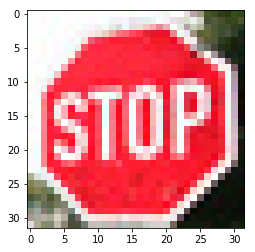

In [8]:
%matplotlib inline
pp.imshow(pp.imread('./tfdata/stop.jpg'))
probabilities, prediction = tfc.predict(pp.imread('./tfdata/stop.jpg'))
print('Traffic Sing predicted as Sign: ', prediction[0], 'with probabilities:\n', probabilities)

#### YIELD SIGN - Prediction correct

Traffic Sing predicted as Sign:  13 with probabilities:
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]]


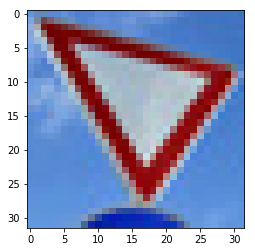

In [18]:
pp.imshow(pp.imread('./tfdata/giveway.jpg'))
probabilities, prediction = tfc.predict(pp.imread('./tfdata/giveway.jpg'))
print('Traffic Sing predicted as Sign: ', prediction[0], 'with probabilities:\n', probabilities)

#### ROUNDABOUT SIGN - Prediction correct

Traffic Sing predicted as Sign:  40 with probabilities:
 [[  0.00000000e+00   0.00000000e+00   1.38070146e-34   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.05774372e-28   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00]]


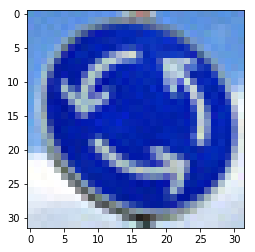

In [17]:
pp.imshow(pp.imread('./tfdata/roundabout.jpg'))
probabilities, prediction = tfc.predict(pp.imread('./tfdata/roundabout.jpg'))
print('Traffic Sing predicted as Sign: ', prediction[0], 'with probabilities:\n', probabilities)

#### 70 SPEED LIMIT SIGN - Prediction incorrect(predicted 60kmh) --> correct prediction is 4(70kmh)

Traffic Sing predicted as Sign:  3 with probabilities:
 [[  2.57953048e-18   2.91062247e-15   1.73809600e-25   1.00000000e+00
    3.18356178e-38   1.51932631e-21   0.00000000e+00   0.00000000e+00
    0.00000000e+00   6.10603974e-34   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.95052820e-19
    1.53021881e-31   0.00000000e+00   6.23186149e-35   0.00000000e+00
    4.46127612e-28   1.57434781e-32   0.00000000e+00   0.00000000e+00
    4.50145717e-32   1.09952615e-37   0.00000000e+00   3.74946259e-24
    1.20234337e-23   1.34078750e-18   0.00000000e+00   8.37520585e-28
    4.69826180e-28   0.00000000e+00   2.13839481e-30   7.16981931e-35
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    5.99284189e-37   4.33660759e-34   0.00000000e+00]]


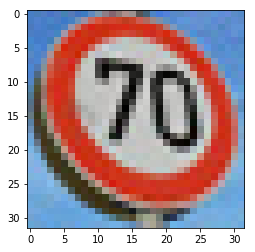

In [16]:
pp.imshow(pp.imread('./tfdata/seventy.jpg'))
probabilities, prediction = tfc.predict(pp.imread('./tfdata/seventy.jpg'))
print('Traffic Sing predicted as Sign: ', prediction[0], 'with probabilities:\n', probabilities)

#### TRAFFIC LIGHTS SIGN - Prediction correct

Traffic Sing predicted as Sign:  26 with probabilities: [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.02226444e-19
    9.83776571e-29   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.56374371e-37   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   9.34243290e-28   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.19777454e-37   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]]


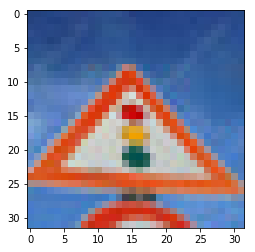

In [15]:
pp.imshow(pp.imread('./tfdata/trafficlights.jpg'))
probabilities, prediction = tfc.predict(pp.imread('./tfdata/trafficlights.jpg'))
print('Traffic Sing predicted as Sign: ', prediction[0], 'with probabilities:\n', probabilities)